In [1]:
from mutedpy.experiments.streptavidin.streptavidin_loader import load_first_round



In [2]:
x,y,dts = load_first_round()
dts

,well,indole,OD,plate_library,variant,norm_TSNAK,Mutation,Fitness,class,Mutation_n,LogFitness
0,E4,0.1225,0.1079,8060.0,TALFQ,30.807874,T111T+S112A+N118L+A119F+K121Q,30.807874,1st-5site,S112A+N118L+A119F+K121Q,1.488662
1,C2,0.1436,0.1270,8057.0,QWNAS,19.585782,T111Q+S112W+N118N+A119A+K121S,19.585782,1st-5site,T111Q+S112W+K121S,1.291941
2,D7,0.1264,0.1399,8061.0,TAQAL,17.675834,T111T+S112A+N118Q+A119A+K121L,17.675834,1st-5site,S112A+N118Q+K121L,1.247380
3,C2,0.1686,0.1685,8069.0,TFGWR,16.727843,T111T+S112F+N118G+A119W+K121R,16.727843,1st-5site,S112F+N118G+A119W+K121R,1.223440
4,B11,0.0704,0.1209,8060.0,HFLSQ,15.801324,T111H+S112F+N118L+A119S+K121Q,15.801324,1st-5site,T111H+S112F+N118L+A119S+K121Q,1.198693
...,...,...,...,...,...,...,...,...,...,...,...
3031,NaN,0.0175,0.2197,NaN,TDNAG,0.652297,T111T+S112D+N118N+A119A+K121G,0.652297,1st-2site,S112D+K121G,-0.185555
3032,NaN,0.0375,0.1022,NaN,TMNAW,3.004814,T111T+S112M+N118N+A119A+K121W,3.004814,1st-2site,S112M+K121W,0.477818
3033,NaN,0.0175,0.1195,NaN,TCNAV,1.199244,T111T+S112C+N118N+A119A+K121V,1.199244,1st-2site,S112C+K121V,0.078907
3034,NaN,0.0330,0.0846,NaN,TVNAW,3.194338,T111T+S112V+N118N+A119A+K121W,3.194338,1st-2site,S112V+K121W,0.504381


In [3]:
mask5_site = dts['class']=='1st-5site'
mask2_site = dts['class']=='1st-2site'
print ("5-site")
print ("Total",len(dts[mask5_site]['variant']))
print ("Unique",len(dts[mask5_site]['variant'].unique()))

5-site
Total 2211
Unique 2083


In [4]:
print ("All")
print ("Total",len(dts['variant']))
print ("Unique",len(dts['variant'].unique()))

All
Total 3036
Unique 2465


In [5]:
from scipy.stats import shapiro
from mutedpy.protein_learning.regression.regression_ards import ARDModelLearner, ProteinKernelLearner
from stpy.helpers.helper import estimate_std
from mutedpy.utils.sequences.sequence_utils import from_integer_to_variants
import torch 
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from scipy.stats import norm
import numpy as np 

(CVXPY) Jan 10 11:38:20 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Jan 10 11:38:20 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


2024-01-10 11:38:20.517429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 11:38:20.739810: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-10 11:38:21.414561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-10 11:38:21.414616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [6]:
residuals_mean_list, out, counts, residuals_mean, indices = estimate_std(x,y,verbose=True, return_all_residuals=True)
print ("Estimate of residuals")
s = estimate_std(x,y,verbose=True)

Estimating variance from: torch.Size([1082])
Estimate of residuals
Estimating variance from: torch.Size([1082])


In [7]:
out, indices, counts = torch.unique(x, dim=0, return_inverse=True, return_counts=True)

In [8]:
print ("Data points from variants that appear at least once")
torch.sum(counts > 1)

Data points from variants that appear at least once


tensor(511)

In [9]:
s = estimate_std(x,y,verbose=True)
print ("Estimate of the std.", s)

Estimating variance from: torch.Size([1082])
Estimate of the std. tensor(0.1457, dtype=torch.float64)


In [10]:
# iterate over large counts and select means and values
on_x_axis = []
on_x_axis_mean = []
means = []
vals = []
stds = []
variants = from_integer_to_variants(out)
for i in range(counts.size()[0]):
    if counts[i] > 2:
        mask = indices == i
        for _ in range(counts[i]):
            on_x_axis.append(variants[i])
        on_x_axis_mean.append(variants[i])
        mean = torch.mean(y[mask].view(-1))
        means.append(mean)
        vals += y[mask].view(-1).tolist()
        stds.append(float(torch.std(y[mask].view(-1))))

In [11]:
print (stds)
ordering = np.argsort(np.array(stds))
on_x_axis_mean = np.array(on_x_axis_mean)[ordering]
means = np.array(means)[ordering]


[0.013012086892616459, 0.05012818228366307, 0.0634237953027836, 0.11826835686266388, 0.2449925047867013, 0.05827004759117094, 0.16171270077211855, 0.3163385208318888, 0.20410356313507041, 0.14415538518316834, 0.09793074250362166, 0.3179898709852404, 0.08014072908229641, 0.5418472749815144, 0.1563218718912152, 0.22480020833829573, 0.23857806653604513, 0.26030718555599686, 0.3383014654087382, 0.18212192809447733, 0.33170858154822996, 0.160013130763731, 0.5033306871647378, 0.06705971928634573, 0.38104141239504136, 0.4642286374594999, 0.18312489638761847, 0.25642042734042925, 0.07822049256606334, 0.2194154516123318, 0.07487992490186045, 0.1136046760331993, 0.22707230524272556, 0.13925464766456772]


/tmp/ipykernel_14665/3134968922.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(on_x_axis_mean)
/tmp/ipykernel_14665/3134968922.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(on_x_axis_mean, rotation = 90)
/tmp/ipykernel_14665/3134968922.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(bottom=0.20, right = 1.05, left = 0.0)
/tmp/ipykernel_14665/3134968922.py:28: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Noise-analysis.pdf", dpi = 200,bbox_inches='tight')
/tmp/ipykernel_14665/3134968922.py:28: UserWarning: There are no gridspecs with layoutgrids. Possibly did not 

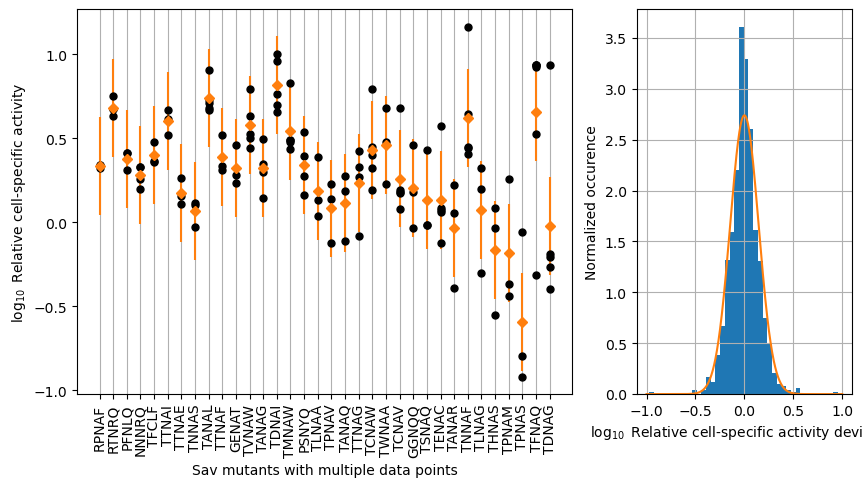

In [12]:
fig = plt.figure(figsize=(10, 5),constrained_layout=True)
gs = GridSpec(nrows=1, ncols=3, wspace=0.3)

ax0 = fig.add_subplot(gs[0, 0:2])
ax0.errorbar(on_x_axis_mean,means,yerr =2*s, marker = 'D',color = "tab:orange",linestyle = "", ms = 5)
ax0.set_xticklabels(on_x_axis_mean)
ax0.set_xticklabels(on_x_axis_mean, rotation = 90)

ax0.plot(on_x_axis,vals,'ko', ms = 5)
#ax0.plot(on_x_axis_mean,np.array(stds)[ordering],'bo', ms = 5)



ax0.xaxis.grid(True)
#plt.grid("--", color = 'gray')
ax0.set_xlabel("Sav mutants with multiple data points")
ax0.set_ylabel("$\log_{10}$ Relative cell-specific activity")

ax1 = fig.add_subplot(gs[0, 2])
ax1.hist(residuals_mean, density = True, bins = 40, color = 'tab:blue')
x_axis = np.linspace(-1,1, 1000)
ax1.plot(x_axis, norm.pdf(x_axis, 0., s), color = 'tab:orange')
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.set_ylabel("Normalized occurence")
ax1.set_xlabel("$\log_{10}$ Relative cell-specific activity deviation")
plt.subplots_adjust(bottom=0.20, right = 1.05, left = 0.0)
plt.savefig("Noise-analysis.pdf", dpi = 200,bbox_inches='tight')

In [13]:
for i in range(counts.size()[0]):
    if counts[i] > 4:
        mask = indices == i
        print (shapiro(y[mask].view(-1)))

ShapiroResult(statistic=0.7807009220123291, pvalue=0.055888962000608444)
ShapiroResult(statistic=0.7591890096664429, pvalue=0.03612465038895607)
ShapiroResult(statistic=0.693771481513977, pvalue=0.008233316242694855)
ShapiroResult(statistic=0.8771700859069824, pvalue=0.2966834306716919)
ShapiroResult(statistic=0.9162543416023254, pvalue=0.5060703754425049)
ShapiroResult(statistic=0.7119845151901245, pvalue=0.012727966532111168)
ShapiroResult(statistic=0.8109756708145142, pvalue=0.09926817566156387)
ShapiroResult(statistic=0.6822947263717651, pvalue=0.006194599438458681)
ShapiroResult(statistic=0.6717005968093872, pvalue=0.0030683064833283424)
ShapiroResult(statistic=0.924537181854248, pvalue=0.559621274471283)


In [14]:
from mutedpy.experiments.streptavidin.streptavidin_loader import load_second_round
from mutedpy.experiments.streptavidin.streptavidin_loader import load_third_round, load_last_round

In [15]:
x2,y2,dts2 = load_second_round()
x3,y3,dts3 = load_third_round()
x4,y4,dts4 = load_last_round()

In [16]:
print ("Second round variants", len(dts2))
print (dts2['class'].value_counts())

Second round variants 514
class
2nd_chimera               213
2nd_informative           202
2nd_hypothesis_testing     36
2nd_optimistic-diverse     29
2nd_safe                   18
2nd_balanced               16
Name: count, dtype: int64


In [17]:
print ("Third round variants", len(dts3))
print (dts3['class'].value_counts())

Third round variants 868
class
3rd_NAN_chimera     362
3rd_geo_safe         91
3rd_ro_safe          89
3rd_ro_balanced      87
3rd_aa_balanced      87
3rd_geo_balanced     86
3rd_aa_safe          66
Name: count, dtype: int64


In [18]:
print ("Fourth round variants", len(dts4))
print (dts4['class'].value_counts())

Fourth round variants 552
class
4th_balanced               71
4th_safe                   65
4th_5-safe                 11
4th_5-balanced             11
4th_top10-5-balanced       10
4th_aa-5-safe               7
4th_aa-5-balanced           5
4th_aa-top10-5-balanced     4
Name: count, dtype: int64


In [2]:
# Noise analysis in the subseqeunt rounds

In [3]:
from mutedpy.experiments.streptavidin.active_learning.compare_different_models import load_model_and_mean_std, load_model

(CVXPY) Jan 12 09:28:47 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')
(CVXPY) Jan 12 09:28:47 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Version of ortools (9.4.1874) is too old. Expected >= 9.5.0.')


2024-01-12 09:28:47.527032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 09:28:47.737132: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 09:28:48.869752: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-12 09:28:48.869876: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [4]:

GP, embed, model_dict = load_model("/home/mojko/Documents/PhD_Projects/protein-design-pet/mutedpy/experiments/streptavidin/active_learning_3/AA_model/params/final_model_params_Jan_05.p","fit, before update",model_params_return=True)


Fitting fit, before update
{'kappa': 3.0, 'group': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'ard_gamma': tensor([ 7.8137e+00,  5.4357e+00,  2.8166e+00,  2.8939e+00,  4.1474e+01,
         3.6573e+00,  9.8912e+00,  4.7052e+00,  5.3773e+00,  6.5864e+00,
         1.4200e+01, -2.0355e+00,  1.0914e+05,  5.0735e+00,  5.8495e-01,
         7.0306e+00,  1.2471e+01,  2.6259e+00,  4.2813e+00,  5.3976e+00],
       dtype=torch.float64), 'nu': 2.5}


In [10]:
import torch
torch.unique(torch.diag(GP.Sigma))

tensor([0.1150, 0.1457, 0.2031], dtype=torch.float64)